In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import utilities3
import importlib
importlib.reload(utilities3)

torch.manual_seed(0)
np.random.seed(0)

In [2]:
#Complex multiplication
def compl_mul3d(a, b):
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    op = partial(torch.einsum, "bixyz,ioxyz->boxyz")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

################################################################
# 3d fourier layers
################################################################

class SpectralConv3d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d_fast, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.rfft(x, 3, normalized=True, onesided=True)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.in_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, 2, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.irfft(out_ft, 3, normalized=True, onesided=True, signal_sizes=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class SimpleBlock3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(SimpleBlock3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.fc0 = nn.Linear(13, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)


        self.conv0 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]

        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn0(x1 + x2)
        x = F.relu(x)
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn1(x1 + x2)
        x = F.relu(x)
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn2(x1 + x2)
        x = F.relu(x)
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn3(x1 + x2)


        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Net3d(nn.Module):
    def __init__(self, modes, width):
        super(Net3d, self).__init__()

        """
        A wrapper function
        """

        self.conv1 = SimpleBlock3d(modes, modes, modes, width)


    def forward(self, x):
        x = self.conv1(x)
        return x.squeeze()


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [3]:
ntrain = 1000
ntest = 200

modes = 4
width = 20

batch_size = 10
batch_size2 = batch_size

epochs = 10
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5

sub = 1
S = 64 // sub
T_in = 10
T = 10

In [4]:
reader = utilities3.MatReader('data/NavierStokes_V1e-5_N1200_T20.mat')
train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]

reader = utilities3.MatReader('data/NavierStokes_V1e-5_N1200_T20.mat')
test_a = reader.read_field('u')[-ntest:,::sub,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,::sub,T_in:T+T_in]

In [5]:
print(f'The shape of train_a is {train_a.shape} and the shape of train_u is {train_u.shape}')
print(f'The shape of test_a is {test_a.shape} and the shape of test_u is {test_u.shape}')

The shape of train_a is torch.Size([1000, 64, 64, 10]) and the shape of train_u is torch.Size([1000, 64, 64, 10])
The shape of test_a is torch.Size([200, 64, 64, 10]) and the shape of test_u is torch.Size([200, 64, 64, 10])


In [6]:
a_normalizer = utilities3.UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = utilities3.UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
test_a = test_a.reshape(ntest,S,S,1,T_in).repeat([1,1,1,T,1])

In [7]:
print(f'The shape of train_a is {train_a.shape} and the shape of test_a is {test_a.shape}')

The shape of train_a is torch.Size([1000, 64, 64, 10, 10]) and the shape of test_a is torch.Size([200, 64, 64, 10, 10])


In [8]:
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])

In [9]:
train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridx.repeat([ntest,1,1,1,1]), gridy.repeat([ntest,1,1,1,1]),
                       gridt.repeat([ntest,1,1,1,1]), test_a), dim=-1)

In [10]:
print(f'The shape of train_a is {train_a.shape} and the shape of test_a is {test_a.shape}')

The shape of train_a is torch.Size([1000, 64, 64, 10, 13]) and the shape of test_a is torch.Size([200, 64, 64, 10, 13])


In [11]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

In [12]:
device = torch.device('cuda')

In [13]:
model = Net3d(modes, width).cuda()
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

print(model.count_params())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)


myloss = utilities3.LpLoss(size_average=False)
y_normalizer.cuda()

824137


In [34]:
train_loss =[]
test_loss =[]
for ep in range(500):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
#         print(l2)
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
    train_loss.append(train_l2/ntrain)

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
        test_loss.append(test_l2/ntest)

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

0 10.583246400000007 0.05903191320598125 0.15295271062850951 0.18358963131904601
1 10.591162499999882 0.05801231883466244 0.1510803152322769 0.18474727153778076
2 10.737484499999937 0.057778379321098326 0.15069750702381135 0.18721493422985078
3 10.711628000000019 0.058042585738003256 0.15102180969715118 0.19241267681121826
4 10.748440099999925 0.05927675113081932 0.15353389847278595 0.18180723667144774
5 10.695599299999913 0.05683100830763579 0.14903019845485688 0.18424175620079042
6 10.666969999999992 0.056694225631654264 0.1491486748456955 0.18147330045700072
7 10.719375300000138 0.05609252333641052 0.14826858460903167 0.18747081577777863
8 10.713965099999996 0.05700494159013033 0.1495420745611191 0.1825929993391037
9 10.685025100000075 0.058007392026484014 0.15118074810504914 0.18068925321102142
10 11.693458599999985 0.05594514723867178 0.14809063661098482 0.18534306406974793
11 11.279394599999932 0.05591140240430832 0.1476339735984802 0.18587984681129455
12 11.640292600000066 0.056

101 10.708776099999795 0.04014572715386748 0.12168113732337951 0.17101988494396209
102 10.71987880000006 0.040031539369374515 0.12146725344657898 0.1703717190027237
103 10.66440590000002 0.04012365350499749 0.12145782828330993 0.17172729790210725
104 10.71460900000011 0.04012415578588843 0.12140848642587662 0.17281758844852446
105 10.677400800000214 0.04033487217500806 0.1220155041217804 0.16962171077728272
106 10.707992500000273 0.04015665877610445 0.12155537527799606 0.17290548384189605
107 10.687041599999702 0.040814388319849966 0.12305546998977661 0.17087368667125702
108 10.674541800000043 0.04105182426050305 0.12327392876148224 0.17601465284824372
109 10.642768100000012 0.04133660281077027 0.1240748440027237 0.1693752884864807
110 10.68699800000013 0.04039758028462529 0.12234361922740936 0.1716123926639557
111 10.616353899999922 0.039549493063241244 0.12044367027282715 0.1697945326566696
112 10.686515800000052 0.039974780641496184 0.12135236346721649 0.17275264739990234
113 10.687

201 10.954560800000309 0.03271212918683886 0.10716384148597717 0.16753322899341583
202 11.019855099999859 0.03264768395572901 0.10709980648756028 0.1683553409576416
203 10.7958050000002 0.032863045185804365 0.10766117417812347 0.1679065728187561
204 10.977611900000284 0.032692342791706325 0.10726037377119065 0.16791461527347565
205 11.385901399999966 0.03236083384603262 0.10652452516555787 0.16826947391033173
206 11.8202739999997 0.032551305945962665 0.10707474774122239 0.17178086280822755
207 11.450537000000168 0.033531574551016095 0.10922616451978684 0.1700499975681305
208 11.432448300000033 0.032334696184843775 0.1063819944858551 0.16804296970367433
209 11.753523800000039 0.03210545018315315 0.10591590303182602 0.16802615106105803
210 11.410178800000267 0.03231999149546027 0.10633827298879624 0.16821402192115784
211 11.399188200000026 0.031987593304365874 0.10561815774440765 0.16814497351646424
212 11.442624600000272 0.03239871801808476 0.10653679013252258 0.16734968721866608
213 11

301 10.76885410000068 0.028286537267267705 0.09770337373018265 0.16746584177017212
302 10.762842899999669 0.02829834498465061 0.09771872985363006 0.16732156693935393
303 10.746369099999356 0.02846252152696252 0.09827094393968581 0.16763952732086182
304 10.736999699999615 0.028657917957752944 0.09865514159202576 0.16763354420661927
305 10.705437699999493 0.02851899031549692 0.09838906621932983 0.16773660600185394
306 10.660332700000254 0.02834849016740918 0.09789312207698822 0.16747728049755095
307 10.740631900000153 0.028297467213124036 0.09788182806968689 0.16754832983016968
308 11.471875899999759 0.028318268116563558 0.09784792238473893 0.16700697243213652
309 10.780798800000412 0.028379846643656493 0.09805463248491288 0.1692214649915695
310 10.860867100000178 0.028508022483438252 0.0984694202542305 0.16796006202697755
311 11.258910300000025 0.028509548287838696 0.09839949947595596 0.16791969776153565
312 11.539171100000203 0.028403810448944567 0.09809434700012207 0.16697053492069244

400 10.653127499999755 0.02618322767317295 0.0930195633172989 0.16798770904541016
401 10.73642910000035 0.026127166152000426 0.09281569772958756 0.16789692401885986
402 10.730465999999979 0.026228882614523174 0.09313119912147522 0.1678505790233612
403 10.644648399999824 0.026195089612156153 0.09302773928642273 0.16776910305023193
404 10.726812899999459 0.026163639817386865 0.0929982544183731 0.16797492146492005
405 10.651318500000343 0.026232583969831465 0.09310825181007386 0.16780505657196046
406 10.700295499999811 0.026200664564967155 0.09304530745744705 0.16807410836219788
407 10.634762800000317 0.026122829727828503 0.09286889547109604 0.16809874355793
408 10.715379899999789 0.026331573761999606 0.09336435496807098 0.16739376723766328
409 10.63815539999996 0.026170936413109303 0.09301885706186294 0.16823331475257874
410 10.744567199999437 0.026117268986999988 0.09286761981248856 0.16756647527217866
411 10.97176859999945 0.026147848535329102 0.09291241055727005 0.16850027620792388
41

499 11.039230600000337 0.025126959737390278 0.09061945921182632 0.16872483670711516


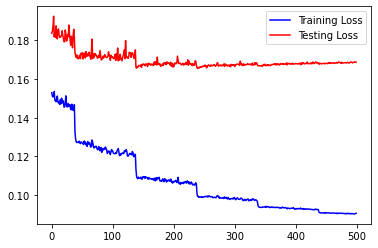

In [36]:
plt.plot(train_loss,'b',label='Training Loss')
plt.plot(test_loss,'r',label='Testing Loss')
plt.legend()
plt.show()

In [37]:
pred = torch.zeros(test_u.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x)
        out = y_normalizer.decode(out)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
#         print(index, test_l2)
        index = index + 1

In [38]:
print(f'The shape of the predictions is {pred.shape} and the shape of actual is {test_u.shape}')

The shape of the predictions is torch.Size([200, 64, 64, 10]) and the shape of actual is torch.Size([200, 64, 64, 10])


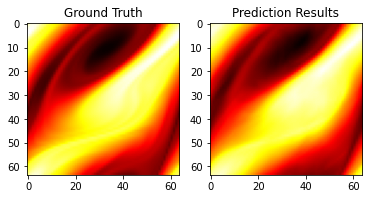

In [39]:
plt.subplot(121)
plt.imshow(test_u[1,:,:,2],cmap='hot')
plt.title('Ground Truth')

plt.subplot(122)
plt.imshow(pred[1,:,:,2],cmap='hot')
plt.title('Prediction Results')
plt.show()

In [40]:
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

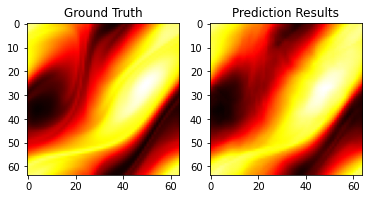

In [41]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax1= fig.add_subplot(122)
ax.title.set_text('Ground Truth')
ax1.title.set_text('Prediction Results')
# ax1.title('Prediction Results')
def plot(i):
    data = test_u[0,:,:,i]
    pred_data = pred[0,:,:,i]
    heatmap = ax.imshow(data,cmap='hot')
    heatmap1= ax1.imshow(pred_data,cmap='hot')
ani = animation.FuncAnimation(fig,plot,interval=10000000,frames=9)
ani.save('NS Results.mp4',writer=writer)